# S&P 500 Classfication Models
Forecasting the financial market is one of the most sought questions in the world, but also one of the biggest challenges any analyst faces. The financial market is constantly evolving, the market participants are constantly learning from the past and adapting their behaviours. The market is also extremely complex due to many non-linear relationships and interactive effects. 

In this project I will go over multiple classification algorithms in an attempt to forecast the market. Specifically, SPDR S&P 500 Trust ETF (SPY) is picked as a convenient way to analyze the S&P 500. Many other related datasets will also be used, such as sector ETFs, foreign exchange rates, commodity futures, and economic data. I will also cover areas such as data preprocessing, feature selection/dimension reduction, hyper-parameter optimization, and model selection. 

Author: Eric Tang

Date: 2020-04-25

## Initialization

In [1]:
#!pip install quandl
!pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in c:\users\yizho\anaconda3\lib\site-packages (0.22.2.post1)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import quandl

#Split
from sklearn.model_selection import train_test_split,TimeSeriesSplit,GridSearchCV
#Feature selection / dimension reduction
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel,RFECV,SelectPercentile,mutual_info_classif
from sklearn.inspection import permutation_importance
#Performance evaluation
from sklearn import metrics

# Classifiers
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, SGDClassifier, LogisticRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

quandl.ApiConfig.api_key = "WLMxat9y7vVtegz9ZEe5"
start = '2000-01-01'
end = '2020-04-17'

np.random.seed(seed=1)

## Datasets
This section consists of three dictionaries, each represent a group of data we will retrieve later in this notebook.

### Group 1:
This group of time series data all share similar characteristics as they are updated every business day. Very low data preprocessing techniques are needed. I choose multiple commodity futures, major foreign exchange pairs, different treasury related data in order to include the daily macro effects around the world.

In [ ]:
#Daily data from Quandl
quandl_dict= {
    #futures
    'gold' :"CHRIS/CME_GC1.4", #Gold Futures, Continuous Contract #1 (GC1) (Front Month)
    'eurodollar': "CHRIS/CME_ED1.4", #Eurodollar Futures, Continuous Contract #1 (ED1) (Front Month)
    'silver': "CHRIS/CME_SI1.4", #Silver Futures, Continuous Contract #1 (SI1) (Front Month)
    'DCOILWTICO': "FRED/DCOILWTICO.4", #Crude Oil Prices: West Texas Intermediate (WTI) - Cushing, Oklahoma
    #major currency pair spot rates
    'USDCAD': "FED/RXI_N_B_CA", #CANADA -- SPOT EXCHANGE RATE, CANADIAN $/US$, Business day
    'EURUSD': "FED/RXI_US_N_B_EU", #SPOT EXCHANGE RATE - EURO AREA, Business day
    'GBPUSD': "FED/RXI_US_N_B_UK", #UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK), Business day
    'USDJPY': "FED/RXI_N_B_JA", #JAPAN -- SPOT EXCHANGE RATE, YEN/US$, Business day
    'AUDUSD': "FED/RXI_US_N_B_AL", #AUSTRALIA -- SPOT EXCHANGE RATE US$/AU$ (RECIPROCAL OF RXI_N.B.AL), Business day
    'NZDUSD': "FED/RXI_US_N_B_NZ", #NEW ZEALAND -- SPOT EXCHANGE RATE, US$/NZ$ RECIPROCAL OF RXI_N.B.NZ, Business day
    'USDCHF': "FED/RXI_N_B_SZ", #SWITZERLAND -- SPOT EXCHANGE RATE, FRANCS/US$, Business day
    'USDNOK': "FED/RXI_N_B_NO", #NORWAY -- SPOT EXCHANGE RATE, KRONER/US$, Business day
    'USDCNY': "FED/RXI_N_B_CH", #CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R., Business day
    'USDINR': "FED/RXI_N_B_IN", #INDIA -- SPOT EXCHANGE RATE, RUPEES/US$, Business day
    'DTWEXM': "FRED/DTWEXM", #Trade Weighted U.S. Dollar Index: Major Currencies
    'DTWEXB': "FRED/DTWEXB", #Trade Weighted U.S. Dollar Index: Broad
    #Interest rates
    'DFF': "FRED/DFF", #Effective Federal Funds Rate
    'DTB3': "FRED/DTB3", #3-Month Treasury Bill: Secondary Market Rate
    'DGS5': "FRED/DGS5", #5-Year Treasury Constant Maturity Rate
    'DGS10': "FRED/DGS10",#10-Year Treasury Constant Maturity Rate
    'DGS30': "FRED/DGS30", #30-Year Treasury Constant Maturity Rate
    'T5YIE': "FRED/T5YIE", #5-year Breakeven Inflation Rate
    'T10YIE': "FRED/T10YIE", #10-year Breakeven Inflation Rate
    'T5YIFR': "FRED/T5YIFR",#5-Year, 5-Year Forward Inflation Expectation Rate 
    'TEDRATE': "FRED/TEDRATE", #TED Spread
    'DPRIME': "FRED/DPRIME" #Bank Prime Loan Rate
}

### Group 2:
While the previous data represents the external macro relationships surrounding the equity market. This group of data represents the internal interactive effects within the U.S. equity market. The VIX index (also known as the fear index) is included to measure the “mood” of the market participants. ETFs that represent different industries are included with a goal to include the effect of different business cycles.

In [ ]:
#Local files (Source: yahoo finance)
local_files = [
    'VIX', #Vix index
    #Sector ETFs:
    'XLE', #Energy Select Sector SPDR Fund 
    'XLF', #Financial Select Sector SPDR Fund
    'XLU', #Utilities Select Sector SPDR Fund
    'XLI', #Industrial Select Sector SPDR Fund
    'XLK', #Technology Select Sector SPDR Fund
    'XLV', #Health Care Select Sector SPDR Fund
    'XLY', #Consumer Discretionary Select Sector SPDR Fund
    'XLP', #Consumer Staples Select Sector SPDR Fund
    'XLB', #Materials Select Sector SPDR Fund
    ]

### Group 3:
The previous two groups allow the models to have an idea of what is happening on a daily basis due to the high frequency of the data. However, in order to measure the financial market, it is also important to look at the lower frequency economic data. This group includes lower frequency data that are released on a monthly/quarterly basis, hence data preprocessing techniques such as forward fill will be needed. The economic indices are chosen in order to
cover the different areas such as growth, inflation, employment, income and expenditure, and debt.


In [ ]:
#econ features that are not daily (weekly, monthly & quarterly data - need to ffill)
sparse_econ_data= {
    #Growth
    'GDP' :"FRED/GDPPOT", #Gross Domestic Product
    'GDPC1': "FRED/GDPC1", #Real Gross Domestic Product
    'GDPPOT': "FRED/GDPC1", #Real Potential Gross Domestic Product
    #Prices and Inflation
    'CPIAUCSL': "FRED/CPIAUCSL", #Consumer Price Index for All Urban Consumers: All Items
    'CPILFESL': "FRED/CPILFESL", #Consumer Price Index for All Urban Consumers: All Items Less Food & Energy
    'GDPDEF': "FRED/GDPDEF", #Gross Domestic Product: Implicit Price Deflator
    #Money Supply
    'BASE': "FRED/BASE", #St. Louis Adjusted Monetary Base
    'M1': "FRED/M1", #M1 Money Stock
    'M2': "FRED/M2", #M2 Money Stock
    'M1V': "FRED/M1V", #Velocity of M1 Money Stock
    'M2V': "FRED/M2V", #Velocity of M2 Money Stock
    #Employment
    'UNRATE': "FRED/UNRATE", #Civilian Unemployment Rate
    'NROU': "FRED/NROU", #Natural Rate of Unemployment (Long-Term)
    'NROUST': "FRED/NROUST", #Natural Rate of Unemployment (Short-Term)
    'CIVPART': "FRED/CIVPART", #Civilian Labor Force Participation Rate
    'EMRATIO': "FRED/EMRATIO", #Civilian Employment-Population Ratio
    'UNEMPLOY': "FRED/UNEMPLOY", #Unemployed level
    'PAYEMS': "FRED/PAYEMS", #All Employees: Total nonfarm
    'MANEMP': "FRED/MANEMP", #All Employees: Manufacturing
    'ICSA': "FRED/ICSA", #Initial Claims
    #Income and Expenditure
    'MEHOINUSA672N': "FRED/MEHOINUSA672N", #Real Median Household Income in the United States
    'DSPIC96': "FRED/DSPIC96", #Real Disposable Personal Income
    'PCE': "FRED/PCE", #Personal Consumption Expenditures
    'PCEDG': "FRED/PCEDG", #Personal Consumption Expenditures: Durable Goods
    'PSAVERT': "FRED/PSAVERT", #Personal Saving Rate
    'RRSFS': "FRED/RRSFS", #Real Retail and Food Services Sales
    'DSPI': "FRED/DSPI", #Disposable personal income
    #Debt
    'GFDEBTN': "FRED/GFDEBTN", #Federal Debt: Total Public Debt
    'GFDEGDQ188S': "FRED/GFDEGDQ188S", #Federal Debt: Total Public Debt as Percent of Gross Domestic Product
    'EXCSRESNW': "FRED/EXCSRESNW", #Excess Reserves of Depository Institutions
    'TOTCI': "FRED/TOTCI", #Commercial and Industrial Loans, All Commercial Banks
    #Other Economic Indicators
    'INDPRO': "FRED/INDPRO", #Industrial Production Index
    'TCU': "FRED/TCU", #Capacity Utilization: Total Industry
    'HOUST': "FRED/HOUST", #Housing Starts: Total: New Privately Owned Housing Units Started
    'GPDI': "FRED/GPDI", #Gross Private Domestic Investment
    'CP': "FRED/CP", #Corporate Profits After Tax (without IVA and CCAdj)
    'STLFSI': "FRED/STLFSI", #St. Louis Fed Financial Stress Index
    'USSLIND': "FRED/USSLIND", #Leading Index for the United States
}


## Construct Target Variable

C:\Users\yizho\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


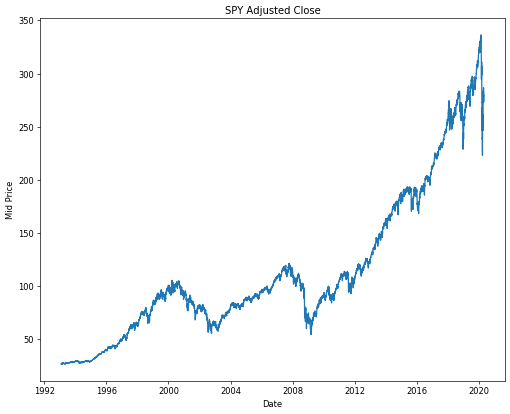

In [4]:
# Import SPY
df = pd.read_csv('SPY.csv',index_col = 'Date',parse_dates = True)

#Visualization
plt.figure(figsize=(10, 8), dpi= 60)
plt.title("SPY Adjusted Close")
plt.plot(df['Adj Close'])
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.show()

#Shift -1 for next day's return
#Classification
df['next_day_SPY_openclose_ret'] = df['Close'].shift(-1)/df['Open'].shift(-1) -1

#If tomorrow's return >= 0, then 1
#If tomorrow's return < 0, then -1
df['y'] = -1
df.at[df['next_day_SPY_openclose_ret'] >= 0,'y'] = 1

#Remove it make sure no look ahead bias
del df['next_day_SPY_openclose_ret']


## Construct Features 
This section mainly consits of the helper functions for me to import the local files and datasets from quandl. Each helper function is created specifically for one of the three datasets. I also wrote an additional feature engineering function to compute additional features from existing ones.

### Helper Functions

In [5]:
#Function to get data from Quandl.
def get_quandl_data(df,quandl_dict,start,end):
    #Iterate through the dictionary of quandl tickers
    for i in quandl_dict:
        quandlCode = quandl_dict[i]
        #retrieve data from quandl API
        df_temp = quandl.get(quandlCode)
        #Rename column
        df_temp.columns = [i]
        #concat input dataframe and the new data
        df = pd.concat([df, df_temp.reindex(df.index)], axis=1)
    #Trim data 
    mask = (df.index>=pd.to_datetime(start)) & (df.index <=pd.to_datetime(end))
    df = df.loc[mask]
    return df

#Function to get data from Quandl.
def get_local_data(df,local_files,start,end):
    for i in local_files:
        fileName = i + '.csv'
        df_temp = pd.read_csv(fileName,index_col='Date',parse_dates = True)
        df_temp = df_temp['Adj Close'].to_frame()
        df_temp.columns = [i]
        df = pd.concat([df, df_temp.reindex(df.index)], axis=1)

    mask = (df.index>=pd.to_datetime(start)) & (df.index <=pd.to_datetime(end))
    df = df.loc[mask]
    return df

#Function to get sparse econ data (frequence != daily) from Quandl.
#Also compute the change in economic data.
#All econ data are preproccessed using ffill.
def get_sparse_econ_data(df,econ_dict,start,end):
    originalIdx = df.index
    for i in econ_dict:
        quandlCode = econ_dict[i]
        df_temp = quandl.get(quandlCode)
        df_temp.columns = [i]
        df_temp[i + '_ret'] = df_temp[i]/df_temp[i].shift(1)-1
        df = pd.concat([df, df_temp], axis=1)
        df[i] = df[i].ffill()
    
    mask = (df.index>=pd.to_datetime(start)) & (df.index <=pd.to_datetime(end))
    df = df.loc[mask]
    df = df.reindex(originalIdx)
    return df

                 Open       High         Low     Close  Adj Close      Volume  \
Date                                                                            
2000-01-03  148.25000  148.25000  143.875000  145.4375  99.394493   8164300.0   
2000-01-04  143.53125  144.06250  139.640625  139.7500  95.507530   8089800.0   
2000-01-05  139.93750  141.53125  137.250000  140.0000  95.678391  12177900.0   
2000-01-06  139.62500  141.50000  137.750000  137.7500  94.140717   6227200.0   
2000-01-07  140.31250  145.75000  140.062500  145.7500  99.608055   8066500.0   

              y   gold  eurodollar  silver  ...   HOUST  HOUST_ret     GPDI  \
Date                                        ...                               
2000-01-03 -1.0    NaN      93.780     NaN  ...  1636.0        NaN  1950.65   
2000-01-04  1.0  283.7      93.795   5.335  ...  1636.0        NaN  1950.65   
2000-01-05 -1.0  282.1      93.790   5.170  ...  1636.0        NaN  1950.65   
2000-01-06  1.0  282.4      93.790   

### Feature Engineering

In [ ]:
#Function to compute additional derived features
#It iterates through each existing feature and compute key statistics (rolling) for multiple lookback periods.
def derive_features(df):
    features = df.columns
    #Iterate through each column in df
    for col in features:
        if col != 'y':
            #Daily change
            df[col+'_ret'] = df[col].pct_change()
            df[col+'_diff'] = df[col].diff()
            
            #Lookback periods
            lookback = [5,21, 63, 126, 252]#1 week, 1 month, 1 quarter, half year, 1 year
            
            #Compute key statistics for each lookback period
            for i in lookback:
                df[col+'_ret_' + str(i)] = df[col]/df[col].shift(i)-1
                #Return-based
                df[col+'_rolling_mean_' + str(i)] = df[col+'_ret'].rolling(i).mean()
                df[col+'_rolling_median_' + str(i)] = df[col+'_ret'].rolling(i).median()
                df[col+'_rolling_stdev_' + str(i)] = df[col+'_ret'].rolling(i).std()
                df[col+ '_rolling_skew_' + str(i)] = df[col+'_ret'].rolling(i).skew()
                df[col+ '_rolling_kurt_' + str(i)] = df[col+'_ret'].rolling(i).kurt()
                df[col+ '_rolling_min_' + str(i)] = df[col+'_ret'].rolling(i).min()
                df[col+ '_rolling_max_' + str(i)] = df[col+'_ret'].rolling(i).max()
                df[col+ '_rolling_corr_' + str(i)] = df[col+'_ret'].rolling(i).corr()
                df[col+ '_ewma_' + str(i)] = pd.DataFrame.ewm(df[col], span= i).mean()
                #Relative level
                df[col+'_rel_lvl_mean_' + str(i)] = df[col]/df[col].rolling(i).mean()
                df[col+'_rel_lvl_min_' + str(i)] = df[col]/df[col].rolling(i).min()
                df[col+'_rel_lvl_max_' + str(i)] = df[col]/df[col].rolling(i).max()                        
    return df

In [ ]:
# Import daily frequency data.
df = get_quandl_data(df,quandl_dict,start,end)
df = get_local_data(df,local_files,start,end)

# Compute additional derived features.
df = derive_features(df)  

# Import economic data from Quandl.
# I did not call the derive_features function for the economic data due to the low frequency nature of the data.
df = get_sparse_econ_data(df,sparse_econ_data,start,end)

df.head()

## Data Preprocessing
With the three groups of data and additional derived features, we have quite a large number of features, however many of them include a lot of NaN values. This section removes the columns that have more than 1% of missing values from our features.

In [6]:
#rmissingvaluecol is a helper function that removes columns that have nans more than the threshold percentage
def rmissingvaluecol(df,threshold):
    l = []
    l = list(df.drop(df.loc[:,list((100*(df.isnull().sum()/len(df.index))>=threshold))].columns, 1).columns.values)
    print("# Columns having more than %s percent missing values:"%threshold,(df.shape[1] - len(l)))
    return l

df = df.replace([np.inf, -np.inf], np.nan)

cols = rmissingvaluecol(df,1) #Here threshold is 1% which means we are going to drop columns having more than 1% of missing values

df_dropped_na= df[cols]

df_dropped_na = df_dropped_na.dropna()

# Columns having more than 1 percent missing values: 1926


## Train/Test Split

In [7]:
#Split data set
X = df_dropped_na.loc[:, df_dropped_na.columns != 'y']
y = df_dropped_na.loc[:, df_dropped_na.columns == 'y']

#Test set uses 33% of the data, no shuffle since we're dealing with time series.
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)

#Summary
print("Train/Test Split Results:")
print("X Train Set:")
print(X_train_raw.shape)
print("X Test Set:")
print(X_test_raw.shape)

Train/Test Split Results:
X Train Set:
(3345, 1006)
X Test Set:
(1649, 1006)


## Standardization
Standardize features by removing the mean and scaling to unit variance.

In [8]:
#Initialize and fit scaler
scaler = StandardScaler()
#Fit scaler using the training data
scaler.fit(X_train_raw)

#Transform the raw data
X_train_standardized = scaler.transform(X_train_raw)
X_test_standardized = scaler.transform(X_test_raw)

## Univariate Feature Selection¶
Because we currently have a very large number of features, I decided to use univariate feature selection first to "weed out" a group of features first, instead of running a computationally expensive method like RFECV directly,

Due to the non-linear nature of financial data, mutual information is used as opposed to the F-test. The F-test estimates the degree of linear dependency between two random variables. On the other hand, mutual information methods can capture any kind of statistical dependency, but being nonparametric, they require more samples for accurate estimation.

Mutual information (MI) between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency.

In [9]:
#Initialize and fit selector
MI_selector = SelectPercentile(mutual_info_classif, percentile=50)#remove the lower 50% of the features based on MI
MI_selector.fit(X_train_standardized,  y_train.values.ravel())

#Transform
X_train_MI = MI_selector.transform(X_train_standardized)
X_test_MI = MI_selector.transform(X_test_standardized)

#Summary
print("Feature Selection Results - Univariate Feature Selection")
#Summary
print("Filter Result:")
print("Number of features: ",X_train_MI.shape[1])

Feature Selection Results - Univariate Feature Selection
Filter Result:
Number of features:  503


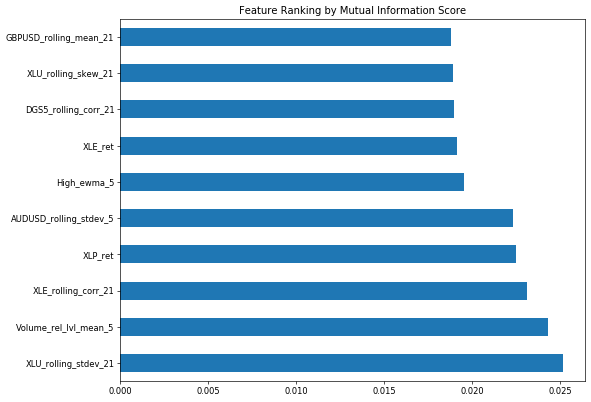

In [10]:
#Rank the features by scores
plt.figure(figsize=(10, 8), dpi= 60)
feat_scores = pd.Series(MI_selector.scores_, index=X_train_raw.columns)
feat_scores.nlargest(10).plot(kind='barh')
plt.title("Feature Ranking by Mutual Information Score")
plt.show()

## Correlation-Based Feature Selection¶
Univariate test allows us to get rid of the variables that have low dependency with our y variable, however as the name suggests, it does not take into account of potential issues such as collinearity. 

In this section I will filter out the highly correlated features to further reduce the dimension of our features.

Correlation Filter Result:
Number of features:  371


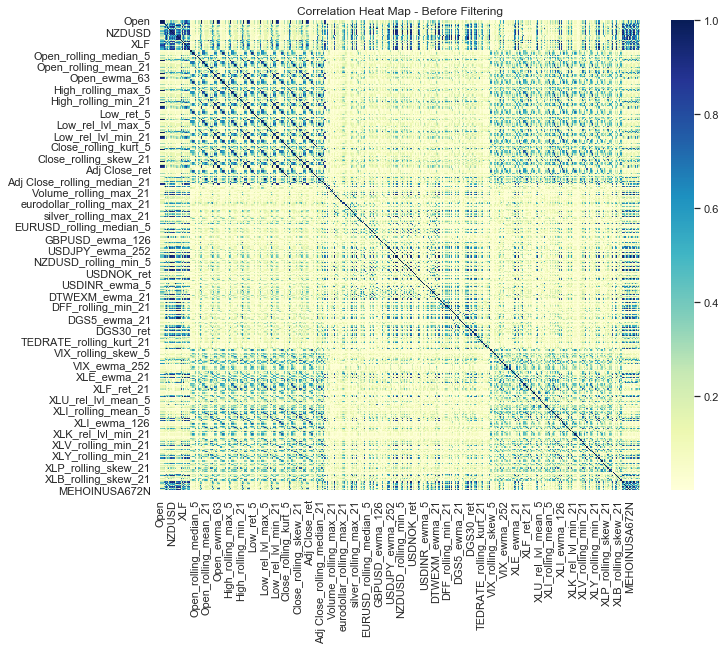

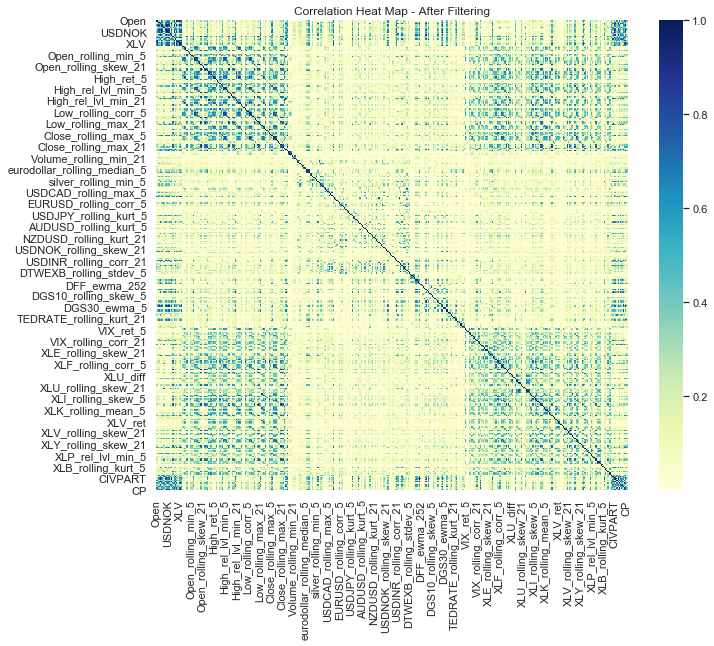

In [11]:
#Function to filter features based on correlation
#X_train and X_test inputs must be dataframes
#Corr_threshold is the cuttoff level for correlation coefficient
def correlation_filter(X_train,X_test,corr_threshold):
    
    #Compute correlation matrix
    corr_matrix = X_train.corr(method = "spearman").abs()
    
    # Select upper triangle of matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))
    
    # Find index of feature columns with correlation greater than user-defined threshold
    to_drop = [column for column in upper.columns if any(upper[column] > corr_threshold)]
    
    # Drop features
    X_train_corr_filtered = X_train.drop(to_drop, axis = 1)
    X_test_corr_filtered = X_test.drop(to_drop, axis = 1)
    
    return X_train_corr_filtered, X_test_corr_filtered

#Helper function for heat map
def heat_map(corr_matrix,title):
    
    sns.set(font_scale = 1.0)
    f, ax = plt.subplots(figsize=(11, 9))
    sns.heatmap(corr_matrix, cmap= "YlGnBu", square=True, ax = ax)
    f.tight_layout()
    ax.set_title(title)

#Initialize dataframes
df_train_MI = pd.DataFrame(data = X_train_MI,
                       index = X_train_raw.index,
                       columns = X_train_raw.columns[MI_selector.get_support()])

df_test_MI = pd.DataFrame(data = X_test_MI,
                       index = X_test_raw.index,
                       columns = X_test_raw.columns[MI_selector.get_support()])

#Filter
X_train_corr, X_test_corr = correlation_filter(df_train_MI,df_test_MI,0.95)

#Correlation heatmap before/after removing highly correlated features (training set)
corr_matrix_before = df_train_MI.corr(method = "spearman").abs()
corr_matrix_after = X_train_corr.corr(method = "spearman").abs()

#Plot heatmaps
heat_map(corr_matrix_before, "Correlation Heat Map - Before Filtering")
heat_map(corr_matrix_after, "Correlation Heat Map - After Filtering")

#Summary
print("Correlation Filter Result:")
print("Number of features: ",X_train_corr.shape[1])

## Recursive Feature Elimination and Cross-Validation

After using two filtering methods (mutual information and correlation), we now move on to a wrapper method RFECV. The RFECV function uses recursive feature elimination to rank the features and use cross-validation to select of the best number of features.

For the base estimator of RFE, I decided to use a Random Forest model with 100 estimators to reduce bias of our models.

Instead of the traditional k-fold cross-validation, sklearn's TimeSeriesSplit (10 splits) is used. This is because we are dealing with time series data. TimeSeriesSplit provides train/test indices to split time series data samples that are observed at fixed time intervals, in train/test sets. In each split, test indices must be higher than before. I believe this is more appropriate since it is very similar to the actual implementation of many quantitative trading strategies in the live market. 

#### Tune Base Estimator - Random Forest
Before performing the actual feature elimination, we need to tune our base estimator of RFECV first.

In this study I decided to use Random Forest as the base estimator for RFECV. If I have access to more computing power, a better approach would be repeating this step for each individual classifier, hence a different subset of features for each individual classifier.

In [ ]:
classifier = RandomForestClassifier()
param_grid = {"n_estimators": [100],
              "class_weight": [None, "balanced"],
              "max_features": ["auto", "sqrt", "log2"],
              "max_depth" : [3, 4, 5, 6, 7, 8],
              "min_samples_split": [0.005, 0.01, 0.05, 0.10],
              "min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
              "criterion" :["gini", "entropy"],
              "n_jobs": [-1]}

# Initialize GridSearch object for random forest
rfc = GridSearchCV(classifier, param_grid, cv = TimeSeriesSplit(n_splits=10), scoring = "accuracy")
                  
# Fit gscv
rfc.fit(X_train_corr, np.ravel(y_train))  

#### Feature Elimination with the Tuned Estimator

In [12]:
rfecv = RFECV(estimator=rfc, step=1, cv=TimeSeriesSplit(n_splits=10), scoring='accuracy')
rfecv.fit(X_train_corr, y_train.values.ravel())

X_train_RFECV = rfecv.transform(X_train_corr)
X_test_RFECV = rfecv.transform(X_test_corr)

#Summary
print("Feature Selection Results - RFECV")
#Summary
print("Filter Result:")
print("Number of features: ",X_train_RFECV.shape[1])

Feature Selection Results - RFECV
Filter Result:
Number of features:  260


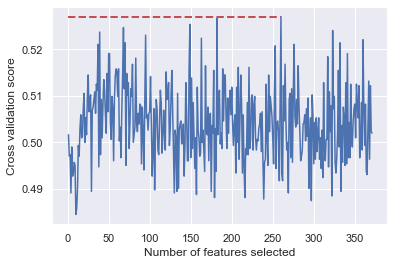

In [13]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.hlines(y=rfecv.grid_scores_.max(), xmin=0, xmax=X_train_RFECV.shape[1], colors='r', linestyles='--', lw=2)
plt.show()

## Feature Importances
Now that we have filtered our original set of features with three different methods, this section studies the final subset set of features by looking at their permutation importances. The reason for not using random forest feature importance is because impurity-based importances are biased towards high cardinality features. (See example:https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html)

In [42]:
forest_clf = rfc.fit(X_train_RFECV, y_train.values.ravel())

PI = permutation_importance(forest_clf, X_train_RFECV, y_train.values.ravel(), n_repeats=10)
#sorted_idx = PI.importances_mean.argsort()
importances = PI.importances_mean
indices = np.argsort(importances)[::-1]
#
#selector = SelectFromModel(forest_clf, prefit=True)
#
#importances = forest_clf.feature_importances_
#indices = np.argsort(importances)[::-1]


#Initialize dataframes
df_X_train_RFECV = pd.DataFrame(data = X_train_RFECV,
                       index = X_train_corr.index,
                       columns = X_train_corr.columns[rfecv.get_support()])

top = 10
# Print the feature ranking
print("Feature ranking and their importances:")

for f in range(top):
    print("%d. feature %s (%f)" % (f + 1, df_X_train_RFECV.columns[indices[f]], importances[indices[f]]))

    
#fig, ax = plt.subplots()
#ax.boxplot(result.importances[sorted_idx].T,
#           vert=False, labels=X_train.columns[sorted_idx])
#ax.set_title("Permutation Importances (train set)")
#fig.tight_layout()
#plt.show()

# Plot the top features
plt.figure(figsize=(10, 8), dpi= 60)
#plot graph of feature importances for better visualization
feat_importances = pd.Series(importances, index=df_X_train_RFECV.columns)
feat_importances.nlargest(top).plot(kind='barh')
plt.title("Feature Importances Ranking")
plt.show()

NameError: name 'permutation_importance' is not defined

## Dimension Reduction - PCA
In this section PCA is applied to further reduce the dimension of our selected features. To preserve the most of amount of information, we keep the number of components that can explain at least 99% of the total variance.

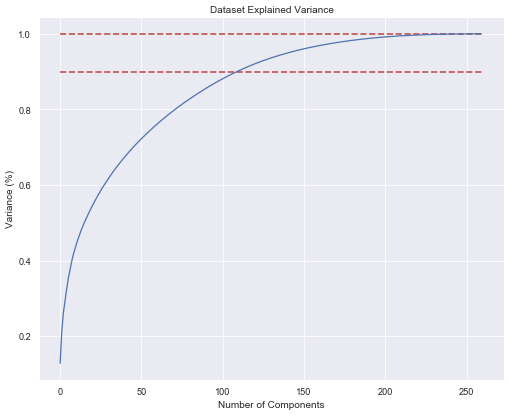

Number of components needed to explain at least 99% of the total variance
197


In [15]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(X_train_RFECV)

#Plotting the Cumulative Summation of the Explained Variance
plt.figure(figsize=(10, 8), dpi= 60)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
#Horizontal lines on 100% & 90%
plt.hlines(y=1, xmin=0, xmax=X_train_RFECV.shape[1], colors='r', linestyles='--', lw=2)
plt.hlines(y=0.9, xmin=0, xmax=X_train_RFECV.shape[1], colors='r', linestyles='--', lw=2)
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Dataset Explained Variance')
plt.show()

#Now we search for the number of components needed for at least 99% of the variance
total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_99 = len(total_explained_variance[total_explained_variance >= 0.99])
n = X_train_RFECV.shape[1] - n_over_99 + 1

print("Number of components needed to explain at least 99% of the total variance")
print(n)


Filtered PCA Features
(3345, 197)


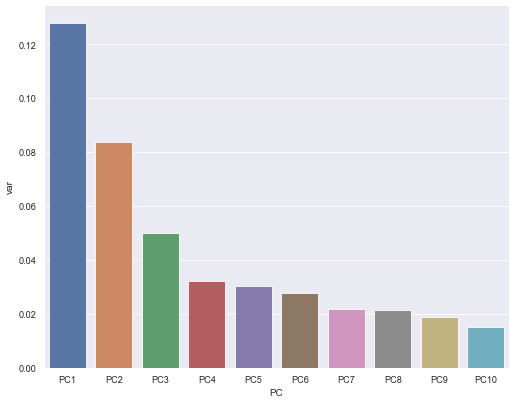

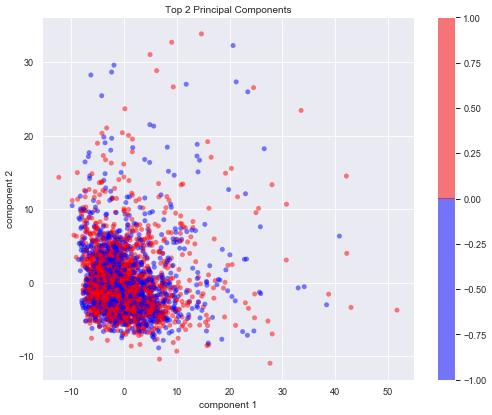

In [16]:
#Using the previous information, initialize a PCA object with n components
pca = PCA(n_components=n)
pca.fit(X_train_RFECV)
#Transform the features
X_train_PCA = pca.transform(X_train_RFECV)
X_test_PCA = pca.transform(X_test_RFECV)

#Data visualization for the first 10 or n (if n<10) components
cols = []
for i in range(1,min(10,n)+1):
    cols.append('PC'+str(i))

#Scree plot
scree = pd.DataFrame({'var':pca.explained_variance_ratio_[0:min(10,n)],
             'PC':cols})
plt.figure(figsize=(10, 8), dpi= 60)
sns.barplot(x='PC',y="var", 
           data=scree);


#The first two principal components
plt.figure(figsize=(10, 8), dpi= 60)
plt.scatter(X_train_PCA[:, 0], X_train_PCA[:, 1],
            c=y_train['y'], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('bwr', 2))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title("Top 2 Principal Components")
plt.colorbar();

print("Filtered PCA Features")
print(X_train_PCA.shape)

## Classification Models
After applying multiple feature selection & dimension reduction to our data, we now move on to the model selection section. The cell below represents the list of different classification models that are included in this research. We will compare different families of classification models from traditional linear models to more sophiscated ensemble-based models. The goal is to evaluate their performances in both in-sample and out-of-sample.

In [17]:
# Create list of tuples with classifier label and classifier object
classifiers = {}
classifiers.update({"Logistic Regression":LogisticRegression()})
classifiers.update({"LDA": LinearDiscriminantAnalysis()})
classifiers.update({"QDA": QuadraticDiscriminantAnalysis()})
classifiers.update({"AdaBoost": AdaBoostClassifier()})
classifiers.update({"Bagging": BaggingClassifier()})
classifiers.update({"Extra Trees Ensemble": ExtraTreesClassifier()})
classifiers.update({"Gradient Boosting": GradientBoostingClassifier()})
classifiers.update({"Random Forest": RandomForestClassifier()})
classifiers.update({"Ridge": RidgeClassifier()})
classifiers.update({"SGD": SGDClassifier()})
classifiers.update({"BNB": BernoulliNB()})
classifiers.update({"GNB": GaussianNB()})
classifiers.update({"KNN": KNeighborsClassifier()})
classifiers.update({"MLP": MLPClassifier()})
classifiers.update({"LSVC": LinearSVC()})
classifiers.update({"NuSVC": NuSVC()})
classifiers.update({"SVC": SVC()})
classifiers.update({"DTC": DecisionTreeClassifier()})
classifiers.update({"ETC": ExtraTreeClassifier()})

## Hyper-parameter Optimization
This section lists the different parameters for each model in our dictionary above.

In [24]:
# Initiate parameter grid
parameters = {}

# Update dict with Logistic Regression
parameters.update({"Logistic Regression": {"solver":["lbfgs"],
                                           "penalty": ["l1", "l2"],
                                           "C": [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100]
                                         }})
# Update dict with LDA
parameters.update({"LDA": {"solver": ["svd", "lsqr", "eigen"], 
                                         }})
# Update dict with QDA
parameters.update({"QDA": {"reg_param":[0.01*ii for ii in range(0, 100)], 
                                         }})
# Update dict with AdaBoost
parameters.update({"AdaBoost": { 
                                "base_estimator": [DecisionTreeClassifier(max_depth = ii) for ii in range(1,6)],
                                "n_estimators": [100],
                                "learning_rate": [0.001, 0.01, 0.05, 0.1, 0.25, 0.50, 0.75, 1.0]
                                 }})
# Update dict with Bagging
parameters.update({"Bagging": { 
                                "base_estimator": [DecisionTreeClassifier(max_depth = ii) for ii in range(1,6)],
                                "n_estimators": [100],
                                "max_features": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                "n_jobs": [-1]
                                }})
# Update dict with Gradient Boosting
parameters.update({"Gradient Boosting": { 
                                        "learning_rate":[0.15,0.1,0.05,0.01,0.005,0.001], 
                                        "n_estimators": [100],
                                        "max_depth": [2,3,4,5,6],
                                        "min_samples_split": [0.005, 0.01, 0.05, 0.10],
                                        "min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                                        "max_features": ["auto", "sqrt", "log2"],
                                        "subsample": [0.8, 0.9, 1]
                                         }})
# Update dict with Extra Trees
parameters.update({"Extra Trees Ensemble": { 
                                            "n_estimators": [100],
                                            "class_weight": [None, "balanced"],
                                            "max_features": ["auto", "sqrt", "log2"],
                                            "max_depth" : [3, 4, 5, 6, 7, 8],
                                            "min_samples_split": [0.005, 0.01, 0.05, 0.10],
                                            "min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                                            "criterion" :["gini", "entropy"]     ,
                                            "n_jobs": [-1]
                                             }})
# Update dict with Random Forest Parameters
parameters.update({"Random Forest": { 
                                    "n_estimators": [100],
                                    "class_weight": [None, "balanced"],
                                    "max_features": ["auto", "sqrt", "log2"],
                                    "max_depth" : [3, 4, 5, 6, 7, 8],
                                    "min_samples_split": [0.005, 0.01, 0.05, 0.10],
                                    "min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                                    "criterion" :["gini", "entropy"]     ,
                                    "n_jobs": [-1]
                                     }})
# Update dict with Ridge
parameters.update({"Ridge": { 
                            "alpha": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.25, 0.50, 0.75, 1.0]
                             }})
# Update dict with SGD Classifier
parameters.update({"SGD": { 
                            "alpha": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.25, 0.50, 0.75, 1.0],
                            "penalty": ["l1", "l2"],
                            "n_jobs": [-1]
                             }})
# Update dict with BernoulliNB Classifier
parameters.update({"BNB": { 
                            "alpha": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.25, 0.50, 0.75, 1.0]
                             }})
# Update dict with GaussianNB Classifier
parameters.update({"GNB": { 
                            "var_smoothing": [1e-9, 1e-8,1e-7, 1e-6, 1e-5]
                             }})
# Update dict with K Nearest Neighbors Classifier
parameters.update({"KNN": { 
                            "n_neighbors": list(range(1,10)),
                            "p": [1, 2],
                            "leaf_size": [30,  40, 50],
                            "n_jobs": [-1]
                             }})
# Update dict with MLPClassifier
parameters.update({"MLP": { 
                            "hidden_layer_sizes": [(5), (10), (5,5), (10,10), (5,5,5), (10,10,10)],
                            "activation": ["identity", "logistic", "tanh", "relu"],
                            "learning_rate": ["constant", "invscaling", "adaptive"],
                            "alpha": list(10.0 ** -np.arange(1, 10)),
                             }})
# Update dict with LSVC
parameters.update({"LSVC": { 
                            "penalty": ["l2"],
                            "C": [0.0001, 0.001, 0.01, 0.1, 1.0, 10, 100]
                             }})
# Update dict with NuSVC
parameters.update({"NuSVC": { 
                            "nu": [0.25, 0.50, 0.75],
                            "kernel": ["linear", "rbf", "poly"],
                            "degree": [1,2,3,4,5,6],
                             }})
# Update dict with SVC
parameters.update({"SVC": { 
                            "kernel": ["linear", "rbf", "poly"],
                            "gamma": ["auto"],
                            "C": [0.1, 0.5, 1, 5, 10, 50, 100],
                            "degree": [1, 2, 3, 4, 5, 6]
                             }})


# Update dict with Decision Tree Classifier
parameters.update({"DTC": { 
                            "criterion" :["gini", "entropy"],
                            "splitter": ["best", "random"],
                            "class_weight": [None, "balanced"],
                            "max_features": ["auto", "sqrt", "log2"],
                            "max_depth" : [1,2,3, 4, 5, 6, 7, 8],
                            "min_samples_split": [0.005, 0.01, 0.05, 0.10],
                            "min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                             }})

# Update dict with Extra Tree Classifier
parameters.update({"ETC": { 
                            "criterion" :["gini", "entropy"],
                            "splitter": ["best", "random"],
                            "class_weight": [None, "balanced"],
                            "max_features": ["auto", "sqrt", "log2"],
                            "max_depth" : [1,2,3, 4, 5, 6, 7, 8],
                            "min_samples_split": [0.005, 0.01, 0.05, 0.10],
                            "min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
                             }})

## Model Fitting and Testing
In this section we will iterate through each classifier, perform grid search for optimal parameters, then record the performance metrics for each model. The performance metrics will include accuracy, precision, recall, F1 score, and AUC. Similar to the previous cross-validation section, all of the CV will be conducted using TimeSeriesSplit (10 splits) instead of the traditional k-fold CV.

In [38]:
## Dataframe to record the results
results = pd.DataFrame(columns=['Train_Accuracy','Test_Accuracy',
                                'Train_Precision','Test_Precision',
                                'Train_Recall','Test_Recall',
                                'Train_F1_Score','Test_F1_Score',
                               'Train_AUC','Test_AUC'],
                       index=list(classifiers.keys()))

for clf_label, clf in classifiers.items(): 
    print("Currently testing: ", clf_label)
    param_grid = parameters[clf_label]
    #Train Model using grid search
    GSCV = GridSearchCV(clf,
                        param_grid,
                        cv = TimeSeriesSplit(n_splits=2),  
                        n_jobs= -1,
                        scoring = "accuracy")

    GSCV.fit(X_train_PCA, y_train.values.ravel())
    
    # Get best parameters and score
    best_params = GSCV.best_params_
    
    # Update classifier parameters and define new pipeline with tuned classifier
    clf.set_params(**best_params)
    
    #Predict - IS: In-Sample, OOS: Out-of-Sample
    y_pred_IS = GSCV.predict(X_train_PCA)
    y_pred_OOS = GSCV.predict(X_test_PCA)
    
    #Compute Accuracy
    results['Train_Accuracy'][clf_label] = metrics.accuracy_score(y_train, y_pred_IS)
    results['Test_Accuracy'][clf_label] = metrics.accuracy_score(y_test, y_pred_OOS)
    
    #Compute Precision
    results['Train_Precision'][clf_label] = metrics.precision_score(y_train, y_pred_IS)
    results['Test_Precision'][clf_label] = metrics.precision_score(y_test, y_pred_OOS)
    
    #Compute Precision
    results['Train_Precision'][clf_label] = metrics.precision_score(y_train, y_pred_IS)
    results['Test_Precision'][clf_label] = metrics.precision_score(y_test, y_pred_OOS)
    
    #Compute Recall
    results['Train_Recall'][clf_label] = metrics.recall_score(y_train, y_pred_IS)
    results['Test_Recall'][clf_label] = metrics.recall_score(y_test, y_pred_OOS)
    
    #Compute F1 Score
    results['Train_F1_Score'][clf_label] = metrics.f1_score(y_train, y_pred_IS,average='weighted')
    results['Test_F1_Score'][clf_label] = metrics.f1_score(y_test, y_pred_OOS,average='weighted')
    
    #Compute AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred_IS)
    results['Train_AUC'][clf_label] = metrics.auc(fpr, tpr)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_OOS)
    results['Test_AUC'][clf_label] = metrics.auc(fpr, tpr)  

Currently testing:  Logistic Regression


C:\Users\yizho\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Currently testing:  LDA
Currently testing:  QDA
Currently testing:  AdaBoost
Currently testing:  Bagging
Currently testing:  Extra Trees Ensemble


C:\Users\yizho\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Currently testing:  Gradient Boosting


C:\Users\yizho\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Currently testing:  Random Forest


C:\Users\yizho\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Currently testing:  Ridge
Currently testing:  SGD


C:\Users\yizho\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Currently testing:  BNB
Currently testing:  GNB
Currently testing:  KNN
Currently testing:  MLP


KeyboardInterrupt: 

## Results
The performance metrics are summarized below.

In [39]:
results

,Train_Accuracy,Test_Accuracy,Train_Precision,Test_Precision,Train_Recall,Test_Recall,Train_F1_Score,Test_F1_Score,Train_AUC,Test_AUC
Logistic Regression,0.608371,0.525773,0.616004,0.561822,0.691135,0.578125,0.6052,0.524999,0.603191,0.520802
LDA,0.607175,0.530018,0.615113,0.565832,0.689441,0.580357,0.60404,0.529352,0.602027,0.525238
QDA,0.776981,0.522135,0.852719,0.539823,0.699605,0.816964,0.776213,0.465864,0.781823,0.49414
AdaBoost,0.542302,0.536082,0.53866,0.544588,0.944099,0.892857,0.436803,0.449825,0.517158,0.502205
Bagging,0.532138,0.533657,0.530931,0.540941,0.998306,0.936384,0.374118,0.416603,0.502965,0.495416
Extra Trees Ensemble,0.529447,0.54336,0.529447,0.54336,1,1,0.366556,0.382593,0.5,0.5
Gradient Boosting,0.529447,0.54336,0.529447,0.54336,1,1,0.366556,0.382593,0.5,0.5
Random Forest,0.529447,0.54336,0.529447,0.54336,1,1,0.366556,0.382593,0.5,0.5
Ridge,0.607474,0.530018,0.615307,0.565689,0.690006,0.581473,0.604318,0.529285,0.602309,0.525132
SGD,0.529447,0.54336,0.529447,0.54336,1,1,0.366556,0.382593,0.5,0.5


In [ ]:
## Backtest funciton

def simple_backtest(df,y_train,y_test,y_pred_IS,y_pred_OS,classifier_name,cost=0.0001):

    #Quick backtest function to plot the hypothetical returns in IS and OOS. 
    df_train = pd.DataFrame(index=y_train.index)
    df_train['signals'] = y_pred_IS
    
    df_test = pd.DataFrame(index=y_test.index)
    df_test['signals'] = y_pred_OS

    
    frames = [df_train,df_test]
    df_backtest = pd.concat(frames)
    df_backtest['Close'] = df['Close']
    df_backtest['Open'] = df['Open']
    df_backtest['next_day_SPY_openclose_ret'] = df_backtest['Close'].shift(-1)/df_backtest['Open'].shift(-1) -1
    df_backtest['cost'] = abs(df_backtest['signals'] - df_backtest['signals'].shift(1))*cost
    df_backtest['returns'] = df_backtest['next_day_SPY_openclose_ret'] *df_backtest['signals']-df_backtest['cost']
    
    
    df_backtest['cumsum'] = df_backtest['returns'].cumsum()

    plt.figure(figsize=(10, 8), dpi= 50)
    plt.axvline(df_train.index[-1],linestyle = '--',color='r')
    plt.title(classifier_name+ ' Backtest Returns')
    plt.plot(df_backtest['cumsum'])


{'C': 10,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l1',
 'random_state': None,
 'solver': 'warn',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

## References
https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html

https://towardsdatascience.com/model-design-and-selection-with-scikit-learn-18a29041d02a
